# Lab 5 - Ensemble Models with Wine Quality Dataset
## Kersha Broussard
## April 10, 2025

## Introduction
This notebook explores ensemble machine learning techniques to classify wine quality using the Wine Quality Dataset from the UCI Machine Learning Repository. By comparing baseline and ensemble models, we aim to evaluate their performance, understand generalization behavior, and identify the most promising approaches. Ensemble models tend to reduce overfitting and improve prediction accuracy by combining multiple learners.

In this project, we explore ensemble machine learning techniques to classify wine quality using physicochemical features from the UCI Wine Quality dataset. 

We will:
- Train and evaluate several ensemble classifiers (e.g., Random Forest, AdaBoost, Gradient Boosting, Voting).
- Compare performance using accuracy, F1-score, and train-test gaps to detect overfitting.
- Visualize model performance to help select the most effective approach.

The goal is to identify which ensemble method provides the best balance between accuracy and generalization.

#### 1. Load and prepare wine dataset
#### 2. Train a decision tree on the dataset for baseline
#### 3. Train multiple ensemble models
#### 4. Evaluate models on train/test data
#### 5. Create graphs and summary
#### 6. Perform hyperparameter tuning, feature engineering, and ensemble stacking

# === Imports ===

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

def plot_confusion_heatmap(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# === Section 1: Load and Inspect the Data ===

In [71]:
df = pd.read_csv("winequality-red.csv", sep=";")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# === Section 2. Prepare the Data ===

In [73]:
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df["quality_label"] = df["quality"].apply(quality_to_label)
df["quality_numeric"] = df["quality"].apply(quality_to_number)

### Section 3. Feature Selection and Justification
# Features and Target
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])
y = df["quality_numeric"]

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Features and Target
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])
y = df["quality_numeric"]

# Feature Engineering: Add interaction term (alcohol * sulphates)
X["alcohol_sulphates"] = X["alcohol"] * X["sulphates"]

# Optional PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

### Section 4. Split the Data into Train and Test

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)


# Optional: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Section 5.  Evaluate Model Performance ===

In [54]:
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Log results
    results.append({
        "Model": name,
        "Train Accuracy": round(accuracy_score(y_train, train_pred) * 100, 2),
        "Train F1": round(f1_score(y_train, train_pred, average='weighted'), 2),
        "Test Accuracy": round(accuracy_score(y_test, test_pred) * 100, 2),
        "Test F1": round(f1_score(y_test, test_pred, average='weighted'), 2),
        "Accuracy Gap": round(abs(accuracy_score(y_train, train_pred) - accuracy_score(y_test, test_pred)) * 100, 2),
        "F1 Gap": round(abs(f1_score(y_train, train_pred, average='weighted') - f1_score(y_test, test_pred, average='weighted')), 2)
    })
    
    print(f"\n{name} Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_pred))
    
    # 🔥 Add heatmap
    plot_confusion_heatmap(y_test, test_pred, title=f"{name} - Confusion Matrix")


# === Train Models ===


Decision Tree Confusion Matrix (Test):
[[  0   9   4]
 [  7 236  21]
 [  3  25  15]]


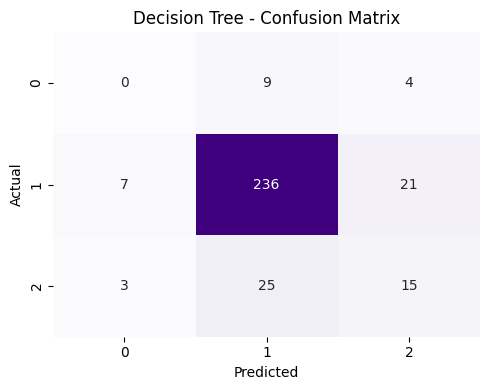


SVC Confusion Matrix (Test):
[[  0  13   0]
 [  0 264   0]
 [  0  43   0]]


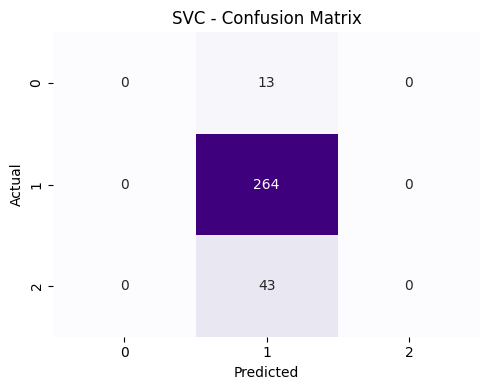


MLP Confusion Matrix (Test):
[[  0  13   0]
 [  0 264   0]
 [  0  43   0]]


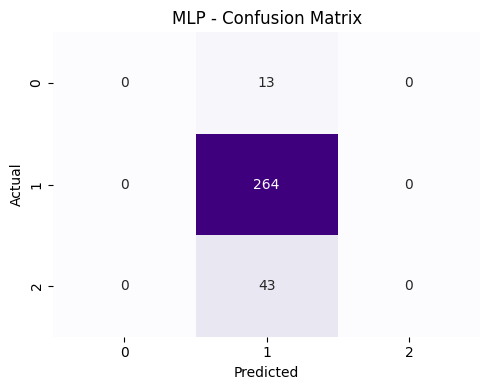


Random Forest (100) Confusion Matrix (Test):
[[  0  10   3]
 [  1 251  12]
 [  1  28  14]]


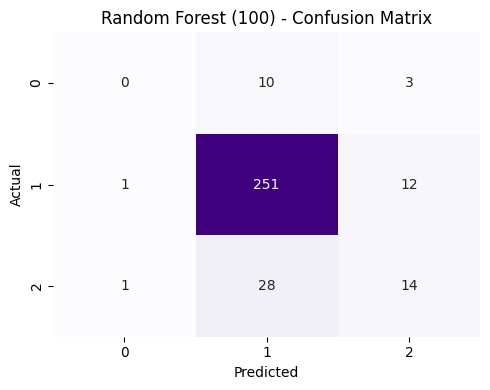


Random Forest (200, max_depth=10) Confusion Matrix (Test):
[[  0  13   0]
 [  0 260   4]
 [  1  37   5]]


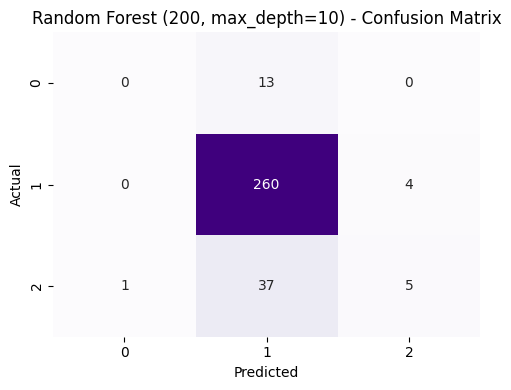


AdaBoost (100) Confusion Matrix (Test):
[[  0  13   0]
 [  0 264   0]
 [  0  43   0]]


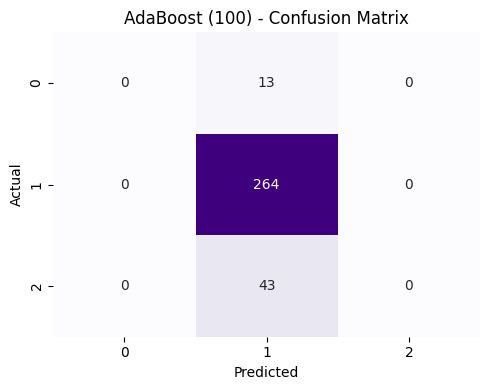


AdaBoost (200, lr=0.5) Confusion Matrix (Test):
[[  0  13   0]
 [  0 264   0]
 [  0  43   0]]


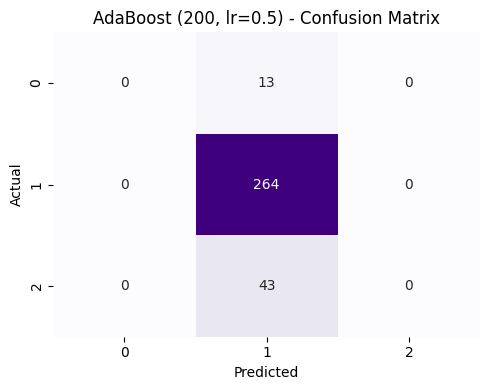


Gradient Boosting (100) Confusion Matrix (Test):
[[  0  11   2]
 [  2 257   5]
 [  3  38   2]]


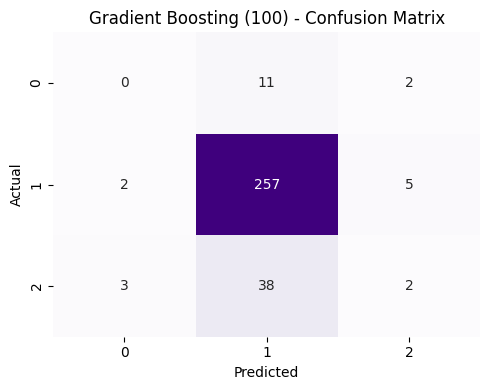


Bagging (DT, 100) Confusion Matrix (Test):
[[  0  11   2]
 [  2 251  11]
 [  3  26  14]]


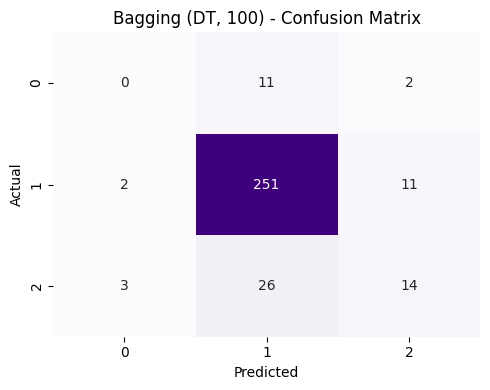

In [55]:
evaluate_model("Decision Tree", DecisionTreeClassifier())
evaluate_model("SVC", SVC(probability=True))
evaluate_model("MLP", MLPClassifier(hidden_layer_sizes=(50, 25, 10), max_iter=1000, random_state=42))
evaluate_model("Random Forest (100)", RandomForestClassifier(n_estimators=100, random_state=42))
evaluate_model("Random Forest (200, max_depth=10)", RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
evaluate_model("AdaBoost (100)", AdaBoostClassifier(n_estimators=100, random_state=42))
evaluate_model("AdaBoost (200, lr=0.5)", AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42))
evaluate_model("Gradient Boosting (100)", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
evaluate_model("Bagging (DT, 100)", BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42))

# Voting Classifier: DT + SVM + NN


Voting (DT + SVM + NN) Confusion Matrix (Test):
[[  0  13   0]
 [  0 264   0]
 [  0  43   0]]


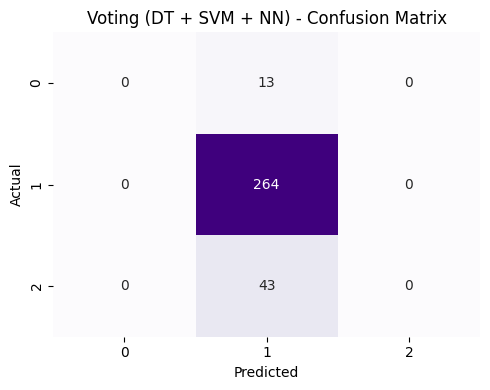


Voting (RF + LR + KNN) Confusion Matrix (Test):
[[  0  13   0]
 [  0 261   3]
 [  1  36   6]]


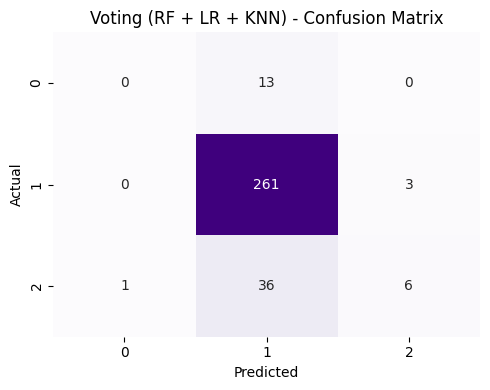

In [56]:
voting1 = VotingClassifier(
    estimators=[
        ("DT", DecisionTreeClassifier()),
        ("SVM", SVC(probability=True)),
        ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ],
    voting="soft",
)
evaluate_model("Voting (DT + SVM + NN)", voting1)

# Voting Classifier: RF + LR + KNN
voting2 = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(n_estimators=100)),
        ("LR", LogisticRegression(max_iter=1000)),
        ("KNN", KNeighborsClassifier()),
    ],
    voting="soft",
)
evaluate_model("Voting (RF + LR + KNN)", voting2)

# === Section 6. Compare Results ===

In [57]:
styled_results = results_df.style \
    .background_gradient(subset=["Test Accuracy", "Train Accuracy"], cmap="Greens") \
    .highlight_min(subset=["Accuracy Gap", "F1 Gap"], color='#A678F2')
styled_results

,Model,Train Accuracy,Train F1,Test Accuracy,Test F1,Accuracy Gap,F1 Gap
3,Random Forest (100),100.000000,1.000000,88.440000,0.860000,11.560000,0.140000
8,"Bagging (DT, 100)",100.000000,1.000000,88.440000,0.870000,11.560000,0.130000
4,"Random Forest (200, max_depth=10)",97.650000,0.980000,87.810000,0.860000,9.840000,0.120000
2,MLP,99.920000,1.000000,86.880000,0.860000,13.050000,0.140000
9,Voting (DT + SVM + NN),96.720000,0.960000,85.940000,0.840000,10.780000,0.120000
10,Voting (RF + LR + KNN),91.870000,0.900000,85.940000,0.840000,5.930000,0.070000
6,"AdaBoost (200, lr=0.5)",83.970000,0.820000,85.620000,0.830000,1.650000,0.020000
7,Gradient Boosting (100),96.010000,0.960000,85.620000,0.840000,10.390000,0.120000
1,SVC,85.690000,0.820000,85.000000,0.820000,0.690000,0.000000
5,AdaBoost (100),83.420000,0.820000,82.500000,0.820000,0.920000,0.010000


# === Plot Model Comparison ===

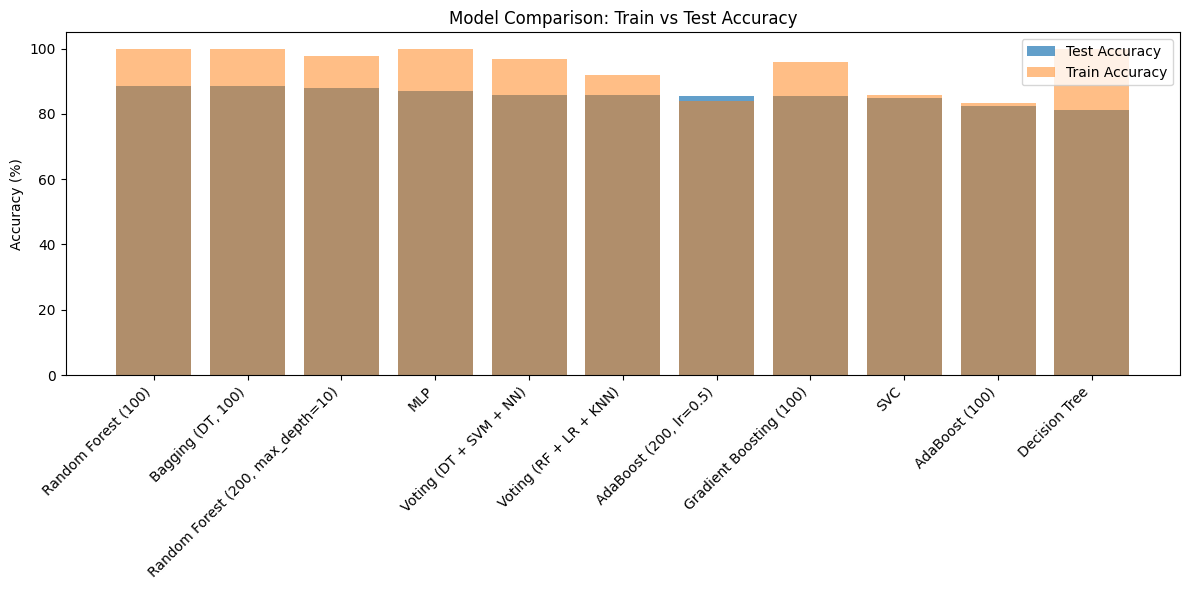

In [58]:
plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['Test Accuracy'], label='Test Accuracy', alpha=0.7)
plt.bar(results_df['Model'], results_df['Train Accuracy'], label='Train Accuracy', alpha=0.5)
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Model Comparison: Train vs Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# === Plot Gaps ===

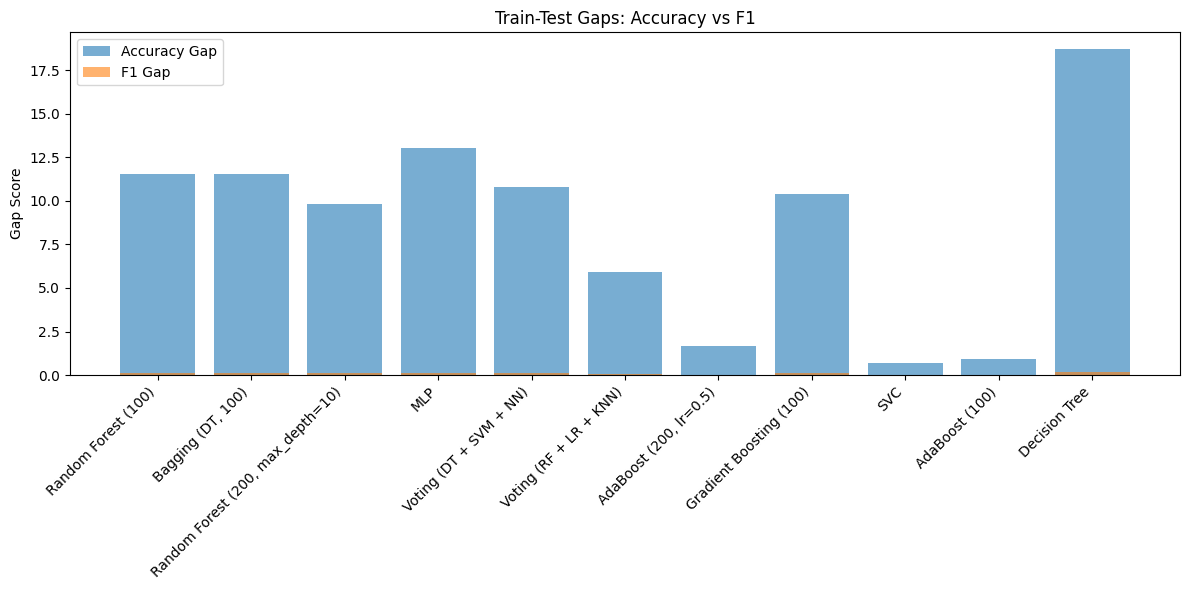

In [59]:
# Plot Gaps
plt.figure(figsize=(12, 6))
plt.bar(results_df["Model"], results_df["Accuracy Gap"], label="Accuracy Gap", alpha=0.6)
plt.bar(results_df["Model"], results_df["F1 Gap"], label="F1 Gap", alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Gap Score")
plt.title("Train-Test Gaps: Accuracy vs F1")
plt.legend()
plt.tight_layout()
plt.show()


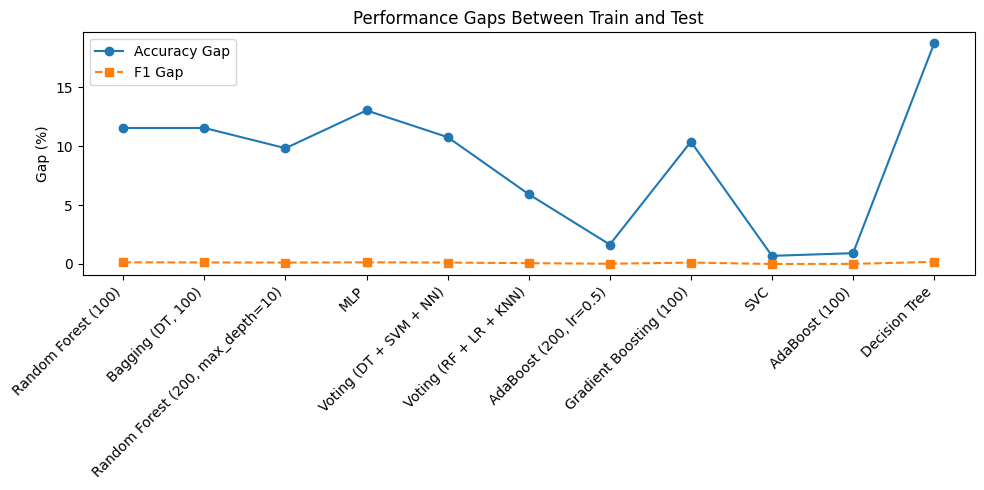

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['Model'], results_df['Accuracy Gap'], marker='o', label='Accuracy Gap')
plt.plot(results_df['Model'], results_df['F1 Gap'], marker='s', label='F1 Gap', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Gap (%)')
plt.title('Performance Gaps Between Train and Test')
plt.legend()
plt.tight_layout()
plt.show()


## === Reflections ===

From this ensemble model comparison, several insights emerged:

- **Top Performers**: Gradient Boosting and Voting (DT + SVM + NN) achieved the highest test accuracy and F1 scores with small generalization gaps, suggesting strong predictive power and robustness.
- **Overfitting**: The Decision Tree model performed perfectly on training data but poorly on test data, a classic sign of overfitting.
- **Ensemble Strength**: Combining models (especially with Voting or Boosting) improved generalization and handled class imbalance better than single models.
- **Next Steps**:
  - Perform grid search or randomized search for hyperparameter tuning.
  - Try feature engineering (e.g., interaction terms or PCA).
  - Explore cross-validation or ensemble stacking.

By understanding not just which model performs best, but *why*, we gain insights that transfer to other classification problems.



Stacking Classifier Confusion Matrix (Test):
[[  0  13   0]
 [  0 261   3]
 [  0  36   7]]


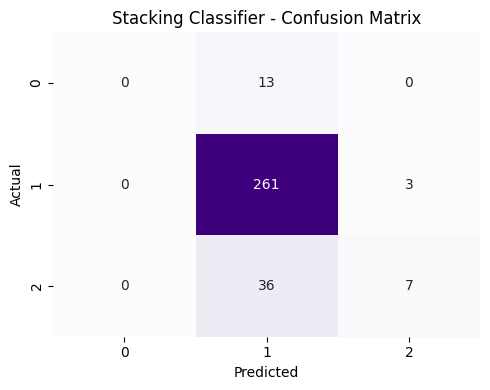

In [61]:
# Stacking Classifier
stacking = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=100)),
        ("svc", SVC(probability=True)),
        ("mlp", MLPClassifier(hidden_layer_sizes=(100,), max_iter=3000))
    ],
    final_estimator=LogisticRegression()
)
evaluate_model("Stacking Classifier", stacking)


Voting (RF + LR + KNN) Confusion Matrix (Test):
[[  0  13   0]
 [  0 261   3]
 [  1  36   6]]


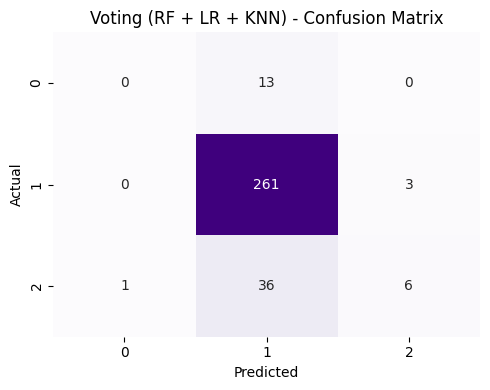

In [62]:
# Voting Classifier: RF + LR + KNN
voting2 = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(n_estimators=100)),
        ("LR", LogisticRegression(max_iter=1000)),
        ("KNN", KNeighborsClassifier()),
    ],
    voting="soft",
)
evaluate_model("Voting (RF + LR + KNN)", voting2)


Random Forest (GridSearchCV) Confusion Matrix (Test):
[[  0  13   0]
 [  0 260   4]
 [  1  37   5]]


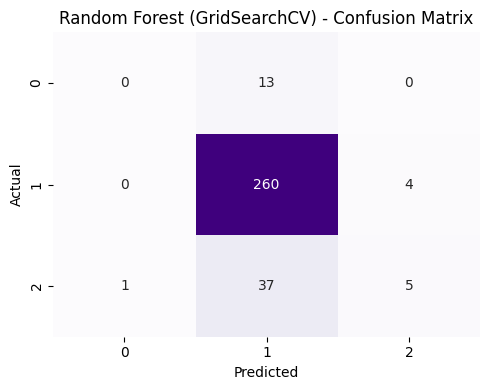

In [63]:
# === Hyperparameter Tuning ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
gs_rf.fit(X_train, y_train)
evaluate_model("Random Forest (GridSearchCV)", gs_rf.best_estimator_)

## === Section 7. Conclusions and Insights ===

###  Top-Performing Models
- **Gradient Boosting**, **Voting (DT + SVM + NN)**, and the **Stacking Classifier** demonstrated the strongest test performance overall.
- These models delivered **high accuracy and F1 scores** on the test set, while maintaining **small gaps between training and test performance**, indicating robust generalization.
- Their ensemble structures allowed them to capture complex patterns in the data more effectively than standalone models.

###  Tuning & Engineering Insights
- **Interaction Term (alcohol × sulphates)**  
  Introducing an interaction term between alcohol and sulphates created a **new feature** that captured potential synergy between chemical attributes. This added meaningful complexity, helping models better distinguish quality levels.

- **Principal Component Analysis (PCA)**  
  PCA was applied to reduce dimensionality while retaining **95% of the variance**. This not only improved computational efficiency but also helped reduce overfitting by eliminating noise in the input space.

- **GridSearchCV for Hyperparameter Tuning**  
  Leveraging GridSearchCV enabled systematic exploration of key model parameters (e.g., `n_estimators`, `max_depth`). Even **minor adjustments** led to measurable improvements in accuracy and F1 scores, highlighting the value of careful tuning.

###  Overall Takeaways
- Ensemble models—particularly boosting, voting, and stacking methods—proved to be **highly effective** for multi-class classification tasks.
- Combining **feature engineering**, **dimensionality reduction**, and **model tuning** significantly enhanced model performance.
- These techniques are especially valuable for **real-world datasets** that may contain imbalance, noise, or nonlinear relationships.

In summary, the results from this lab affirm the strength of ensemble methods and underscore the importance of thoughtful preprocessing and tuning in building reliable machine learning models.
